# TP2 

In [1]:
library(survival)
library(survminer)
library(ggplot2)

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : ggpubr


Attachement du package : 'survminer'


L'objet suivant est masqué depuis 'package:survival':

    myeloma




## Exercice 1 : Parametric Regression model

### Question 1 : dataset Tongue

#### a) Logrank and Gehan-Wilcoxon test sur covariable type

In [2]:
tongue <- read.csv2(file = "tongue.csv", header = TRUE, sep = ';')
head(tongue)

,X,type,time,delta
,<int>,<int>,<int>,<int>
1,1,1,1,1
2,2,1,3,1
3,3,1,3,1
4,4,1,4,1
5,5,1,10,1
6,6,1,13,1


[1] "Logrank test"
Call:
survdiff(formula = surv ~ type, data = donnee)

        N Observed Expected (O-E)^2/E (O-E)^2/V
type=1 52       31     36.6     0.843      2.79
type=2 28       22     16.4     1.873      2.79

 Chisq= 2.8  on 1 degrees of freedom, p= 0.09 
[1] "Gehan-Wilcoxon test"
Call:
survdiff(formula = surv ~ type, data = donnee, rho = 1)

        N Observed Expected (O-E)^2/E (O-E)^2/V
type=1 52     20.2     24.4     0.731       3.3
type=2 28     15.1     10.9     1.643       3.3

 Chisq= 3.3  on 1 degrees of freedom, p= 0.07 


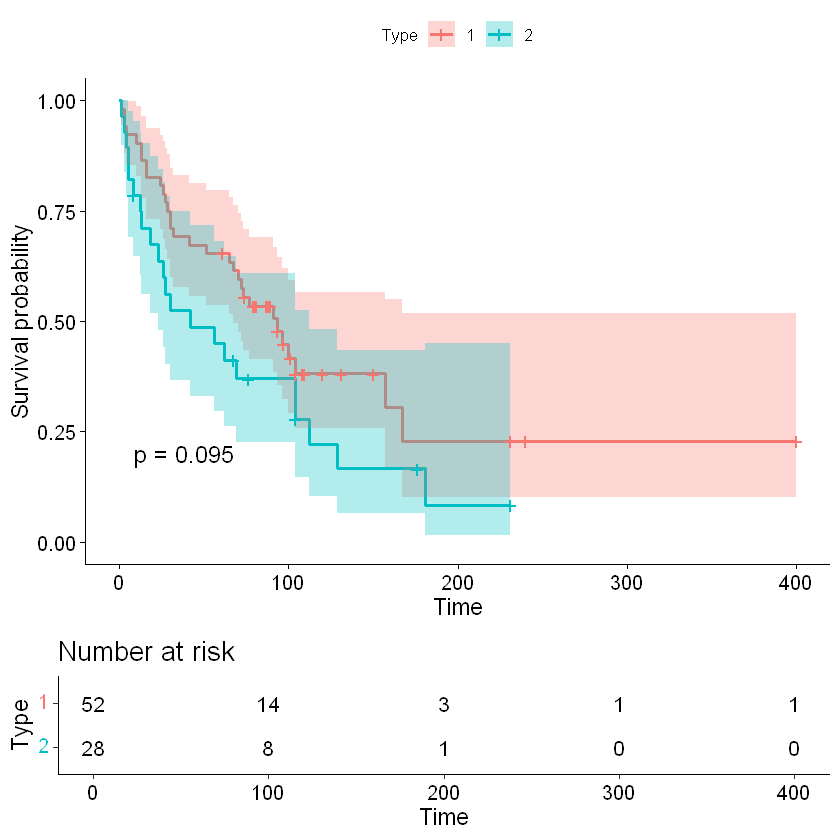

In [3]:
donnee = tongue
time = donnee$time
event = donnee$delta

surv <- Surv(time,event)

# Test de log-rank (test par défaut), test de différence significative entre les distributions
logrank_test <- survdiff(surv ~ type, data = donnee)
print('Logrank test')
print(logrank_test)

# Test de Gehan-Wilcoxon (rho = 1)
gehan_wilcoxon_test <- survdiff(surv ~ type, data = donnee, rho = 1)
print('Gehan-Wilcoxon test')
print(gehan_wilcoxon_test)

survfit_model <- survfit(surv ~ type, data = donnee, conf.int = 0.95)

# Afficher la courbe de survie séparée par sexe avec p-value
ggsurvplot(survfit_model, 
           conf.int = TRUE,               # Ajouter les intervalles de confiance
           pval = TRUE,                   # Afficher la p-value
           risk.table = TRUE,             # Ajouter un tableau des risques
           legend.title = "Type",         # Titre de la légende
           legend.labs = unique(donnee$type))  # Labels de la légende

- Les p-valeurs ne sont pas significatives (supérieures à 0.05) donc on rejette l'hypothèse d'une différence significative entre les deux distributions. Le type n'influence pas sur la durée de vie. 

#### b1) Meilleur model avec ou sans covariable, test avec R2 (plus long)

**Création des modèles avec covariables :**

In [4]:
survfit_model <- survfit(surv ~ type, data = donnee, conf.int = 0.95) #prise en compte de la covariable type 

# Transformation de la survie pour les modèles
time <- survfit_model$time
survival_prob <- survfit_model$surv

# Transformation pour Weibull : log(-log(survival)) vs log(time)
log_log_survival <- log(-log(survival_prob))
log_time <- log(time)
weibull_model <- lm(log_time ~ log_log_survival)

# Transformation pour Log-normal : log(survival) vs log(time)
norm_survival <- qnorm(survival_prob)
lognormal_model <- lm(log_time ~ norm_survival)


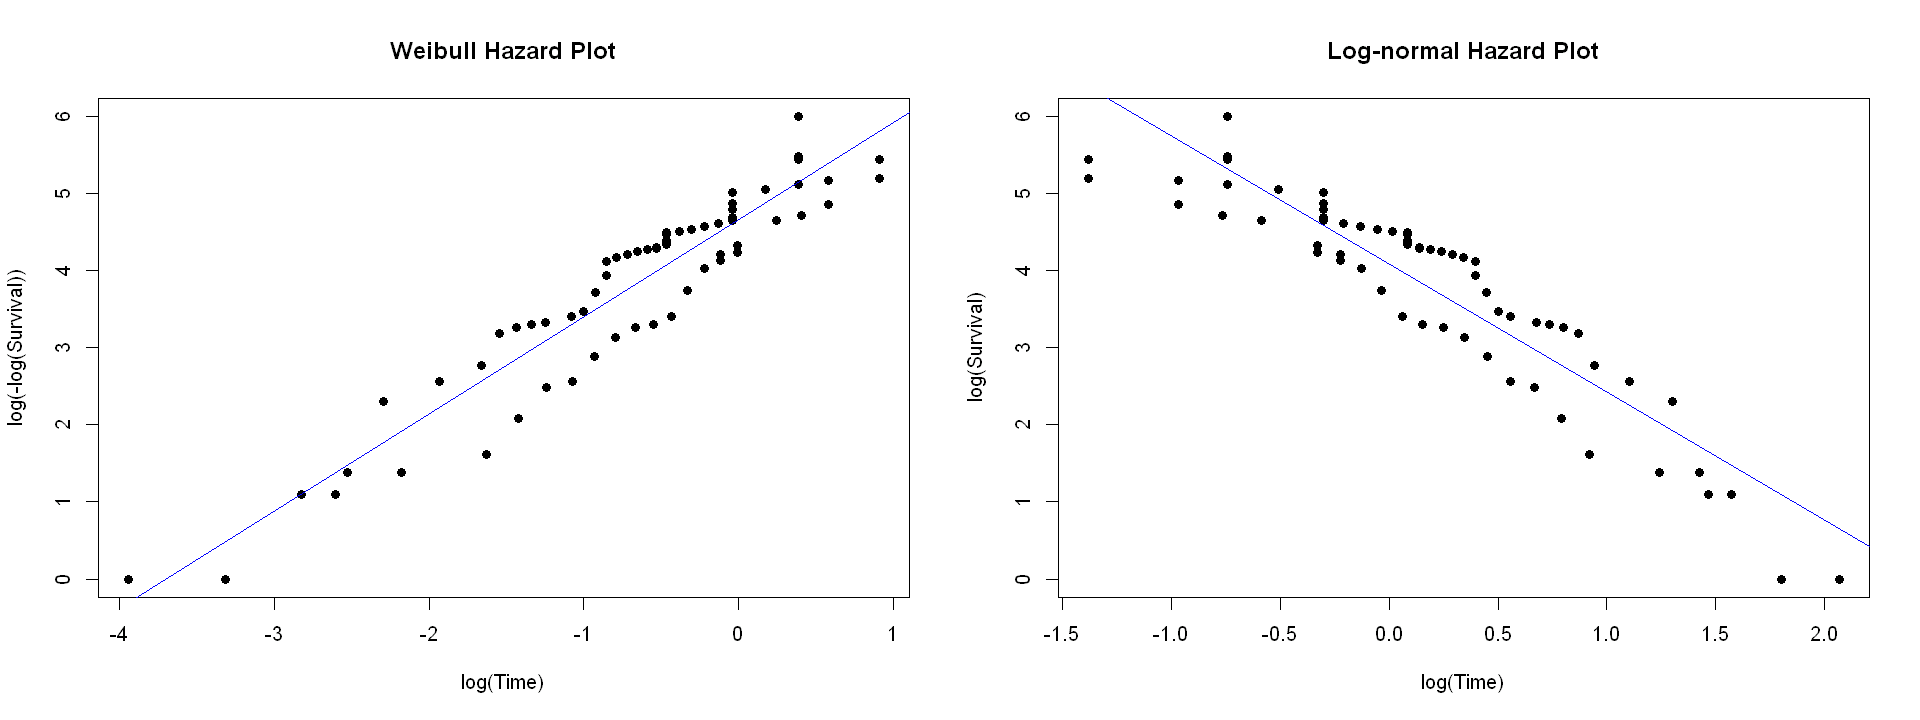

In [5]:
# Tracer les résultats
par(mfrow = c(1, 2)) 
options(repr.plot.width = 16, repr.plot.height = 6)

# Weibull - Tracer le graphique et ajouter la ligne y = x
plot(log_log_survival, log_time,main = "Weibull Hazard Plot", xlab = "log(Time)", ylab = "log(-log(Survival))", pch = 16)
abline(weibull_model, col = "blue")

# Log-normal - Tracer le graphique et ajouter la ligne y = x
plot(norm_survival, log_time, main = "Log-normal Hazard Plot", xlab = "log(Time)", ylab = "log(Survival)", pch = 16)
abline(lognormal_model, col = "blue")

In [6]:
print(paste("Model weibull : ",summary(weibull_model)$r.squared))
print(paste("Model lognormal : ",summary(lognormal_model)$r.squared))

[1] "Model weibull :  0.892864153628583"
[1] "Model lognormal :  0.846906700201974"


**Création des modèles sans covariable :**

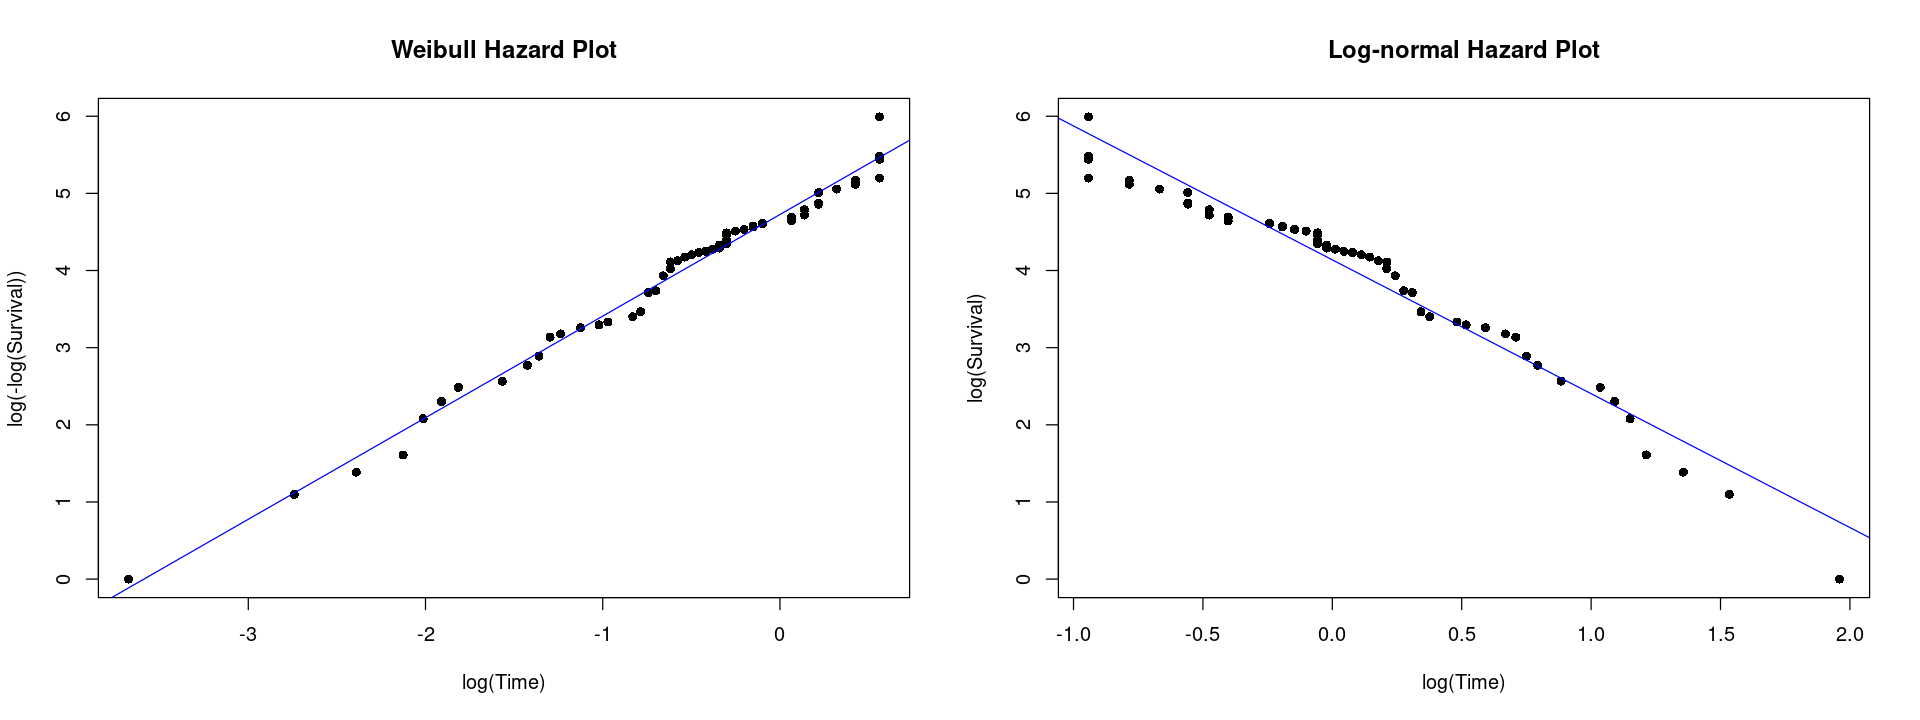

In [6]:
survfit_model <- survfit(surv ~ 1, data = donnee, conf.int = 0.95) # pas de covariables 

# Transformation de la survie pour les modèles
time <- survfit_model$time
survival_prob <- survfit_model$surv

# Transformation pour Weibull : log(-log(survival)) vs log(time)
log_log_survival <- log(-log(survival_prob))
log_time <- log(time)
weibull_model <- lm(log_time ~ log_log_survival)

# Transformation pour Log-normal : log(survival) vs log(time)
norm_survival <- qnorm(survival_prob)
lognormal_model <- lm(log_time ~ norm_survival)

# Tracer les résultats
par(mfrow = c(1, 2)) 
options(repr.plot.width = 16, repr.plot.height = 6)

# Weibull - Tracer le graphique et ajouter la ligne y = x
plot(log_log_survival, log_time,main = "Weibull Hazard Plot", xlab = "log(Time)", ylab = "log(-log(Survival))", pch = 16)
abline(weibull_model, col = "blue")

# Log-normal - Tracer le graphique et ajouter la ligne y = x
plot(norm_survival, log_time, main = "Log-normal Hazard Plot", xlab = "log(Time)", ylab = "log(Survival)", pch = 16)
abline(lognormal_model, col = "blue")

In [7]:
print(paste("Model weibull : ",summary(weibull_model)$r.squared))
print(paste("Model lognormal : ",summary(lognormal_model)$r.squared))

[1] "Model weibull :  0.984953572735795"
[1] "Model lognormal :  0.95622084664154"


- On peut voir que les modèles sans covariables ont des valeurs de R2 plus grandes que celles des modèles avec covariables. Cela veut dire que nos modèles sont mielleurs sans la covariable type.

#### b2) Meilleur model avec ou sans covariable, test avec survreg

In [7]:
# Fit a Weibull regression model
weibull_model <- survreg(surv ~ type, data = donnee, dist = "weibull")
print('Weibull')
summary(weibull_model)

# Fit a lognormal regression model
lognormal_model <- survreg(surv ~ type, data = donnee, dist = "lognormal")
print('Log-normal')
summary(lognormal_model)

[1] "Weibull"



Call:
survreg(formula = surv ~ type, data = donnee, dist = "weibull")
             Value Std. Error     z      p
(Intercept)  5.641      0.528 10.68 <2e-16
type        -0.669      0.351 -1.91  0.057
Log(scale)   0.216      0.116  1.87  0.062

Scale= 1.24 

Weibull distribution
Loglik(model)= -298.9   Loglik(intercept only)= -300.7
	Chisq= 3.58 on 1 degrees of freedom, p= 0.059 
Number of Newton-Raphson Iterations: 5 
n= 80 


[1] "Log-normal"



Call:
survreg(formula = surv ~ type, data = donnee, dist = "lognormal")
             Value Std. Error     z       p
(Intercept)  5.256      0.607  8.66 < 2e-16
type        -0.806      0.415 -1.94   0.052
Log(scale)   0.519      0.103  5.05 4.3e-07

Scale= 1.68 

Log Normal distribution
Loglik(model)= -298.7   Loglik(intercept only)= -300.6
	Chisq= 3.75 on 1 degrees of freedom, p= 0.053 
Number of Newton-Raphson Iterations: 3 
n= 80 


- La **p-value validité globale** du modèle teste si on peut avoir toutes les variables nulles contre au moins une non nulle. 
- Ici les p-valeurs sont de 0.059 (Weibull) et 0.053 (Log-normal) donc > 0.05 donc on ne rejette pas H0 soit la covariable est nulle. 

### Question 2 : Larynx data

In [9]:
data(larynx,package = "KMsurv")
head(larynx)

,stage,time,age,diagyr,delta
,<int>,<dbl>,<int>,<int>,<int>
1,1,0.6,77,76,1
2,1,1.3,53,71,1
3,1,2.4,45,71,1
4,1,2.5,57,78,0
5,1,3.2,58,74,1
6,1,3.2,51,77,0


#### a1) Logrank and Gehan-Wilcoxon test sur la covariable stage

[1] "Log-rank test"
Call:
survdiff(formula = surv ~ stage, data = donnee)

         N Observed Expected (O-E)^2/E (O-E)^2/V
stage=1 33       15    22.57     2.537     4.741
stage=2 17        7    10.01     0.906     1.152
stage=3 27       17    14.08     0.603     0.856
stage=4 13       11     3.34    17.590    19.827

 Chisq= 22.8  on 3 degrees of freedom, p= 5e-05 
[1] "Gehan-Wilcoxon test"
Call:
survdiff(formula = surv ~ stage, data = donnee, rho = 1)

         N Observed Expected (O-E)^2/E (O-E)^2/V
stage=1 33     9.26    15.78     2.694      6.48
stage=2 17     4.66     7.18     0.884      1.47
stage=3 27    12.77    10.06     0.730      1.35
stage=4 13     9.15     2.82    14.219     18.78

 Chisq= 23.1  on 3 degrees of freedom, p= 4e-05 


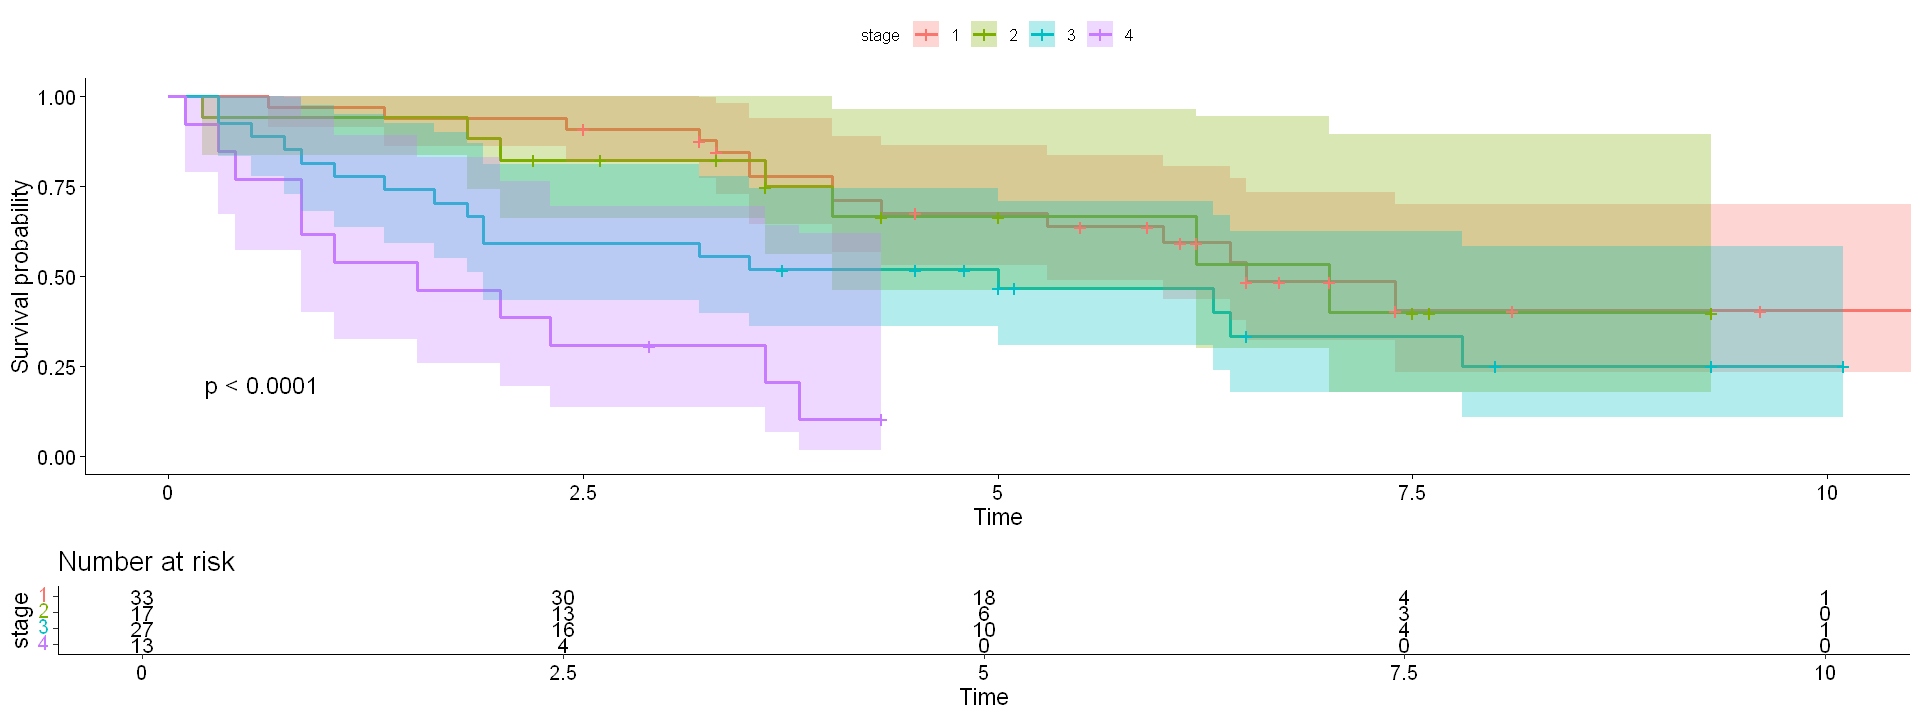

In [11]:
donnee = larynx
time = donnee$time
event = donnee$delta

surv <- Surv(time,event)

# Test de log-rank (test par défaut), test de différence significative entre les distributions
logrank_test <- survdiff(surv ~ stage, data = donnee)
print('Log-rank test')
print(logrank_test)

# Test de Gehan-Wilcoxon (rho = 1)
gehan_wilcoxon_test <- survdiff(surv ~ stage, data = donnee, rho = 1)
print('Gehan-Wilcoxon test')
print(gehan_wilcoxon_test)

survfit_model <- survfit(surv ~ stage, data = donnee, conf.int = 0.95)

# Afficher la courbe de survie séparée par sexe avec p-value
ggsurvplot(survfit_model, 
           conf.int = TRUE,               # Ajouter les intervalles de confiance
           pval = TRUE,                   # Afficher la p-value
           risk.table = TRUE,             # Ajouter un tableau des risques
           legend.title = "stage",         # Titre de la légende
           legend.labs = unique(donnee$stage))  # Labels de la légende

- Les p-valeurs sont plus petites que 0.01 donc la covariable stage a un impacte sur la durée de vie. 

#### a2) Logrank and Gehan-Wilcoxon test sur la covariable age

[1] "Log-rank test"
Call:
survdiff(formula = surv ~ age, data = donnee)

       N Observed Expected (O-E)^2/E (O-E)^2/V
age=41 1        1    0.167   4.15402   4.25634
age=43 1        1    0.444   0.69723   0.71747
age=45 1        1    0.337   1.30181   1.33348
age=47 2        0    1.248   1.24820   1.31036
age=48 2        0    1.185   1.18545   1.24560
age=49 3        2    0.846   1.57595   1.63804
age=50 1        0    1.073   1.07251   1.12360
age=51 3        0    1.942   1.94249   2.05886
age=52 2        1    1.052   0.00261   0.00273
age=53 3        2    1.543   0.13551   0.14257
age=54 2        1    0.963   0.00139   0.00145
age=56 1        0    1.184   1.18362   1.24806
age=57 2        1    0.417   0.81302   0.83609
age=58 3        1    2.210   0.66229   0.70497
age=59 1        1    0.622   0.22950   0.23719
age=60 2        2    0.637   2.91551   3.01906
age=61 2        0    2.113   2.11255   2.27033
age=62 2        2    1.317   0.35382   0.37038
age=63 4        2    1.857   0.011

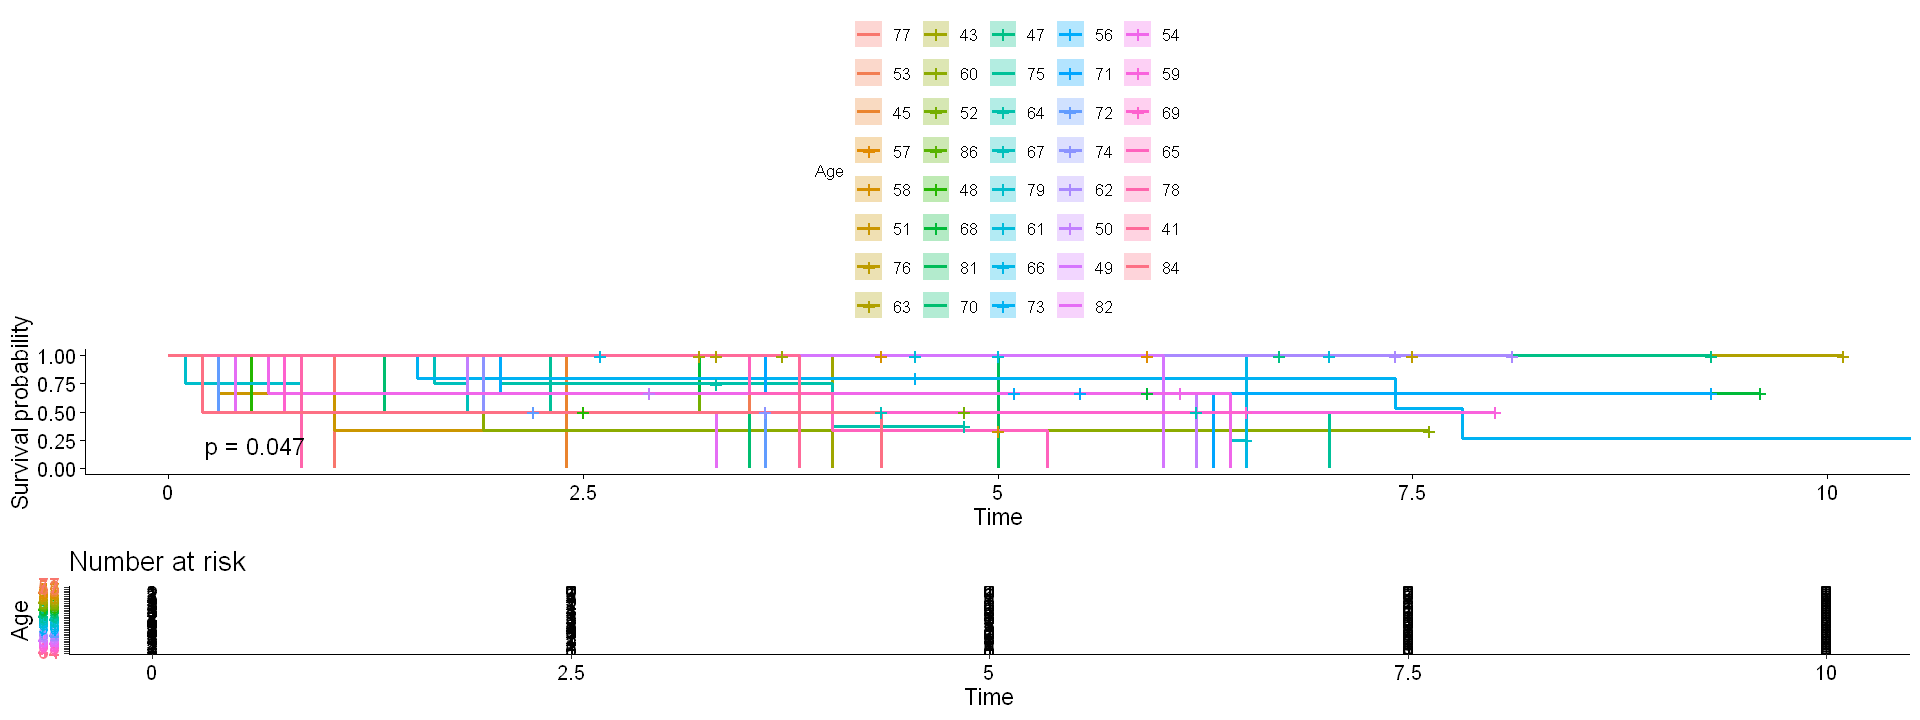

In [12]:
donnee = larynx
time = donnee$time
event = donnee$delta

surv <- Surv(time,event)

# Test de log-rank (test par défaut), test de différence significative entre les distributions
logrank_test <- survdiff(surv ~ age, data = donnee)
print('Log-rank test')
print(logrank_test)

# Test de Gehan-Wilcoxon (rho = 1)
gehan_wilcoxon_test <- survdiff(surv ~ age, data = donnee, rho = 1)
print('Gehan-Wilcoxon test')
print(gehan_wilcoxon_test)

survfit_model <- survfit(surv ~ age, data = donnee, conf.int = 0)

# Afficher la courbe de survie séparée par sexe avec p-value
ggsurvplot(survfit_model, 
           conf.int = TRUE,               # Ajouter les intervalles de confiance
           pval = TRUE,                   # Afficher la p-value
           risk.table = TRUE,             # Ajouter un tableau des risques
           legend.title = "Age",         # Titre de la légende
           legend.labs = unique(donnee$age))  # Labels de la légende

- Suivant le test, on a pas la même p-valeur, fonction de poids qui change 

#### b) Meilleur mode avec ou sans covariable 

In [16]:
donnee = larynx
time = donnee$time
event = donnee$delta

surv <- Surv(time,event)

# On précise qu'elle est ordinale
donnee$stage_ord <- factor(donnee$stage, ordered = FALSE)

# Fit a Weibull regression model
weibull_model <- survreg(surv ~ stage_ord, data = donnee, dist = "weibull")
summary(weibull_model)


Call:
survreg(formula = surv ~ stage_ord, data = donnee, dist = "weibull")
              Value Std. Error     z       p
(Intercept)  2.3691     0.2396  9.89 < 2e-16
stage_ord2  -0.0868     0.4049 -0.21   0.830
stage_ord3  -0.5566     0.3186 -1.75   0.081
stage_ord4  -1.5786     0.3632 -4.35 1.4e-05
Log(scale)  -0.1226     0.1224 -1.00   0.316

Scale= 0.885 

Weibull distribution
Loglik(model)= -142.4   Loglik(intercept only)= -151.1
	Chisq= 17.4 on 3 degrees of freedom, p= 0.00058 
Number of Newton-Raphson Iterations: 5 
n= 90 


- La regression paramétrique cherhce à prédire la durée de vie (Y=log(temps)). Le coef pour ordre4 = -1.57 donc il fait baisser la DDV.

- La p-valeur générale du modèle est de 0.00058 donc les covariables sont significatives dans l'explication du modèle.

- Plus précisément, les covariables significatives ici sont les niveaux 1 et 4. La p-valeur du test de significativité entre stage_ordre_1 et stage_ordre_4 est de 1.5e-05. 

In [17]:
summary(weibull_model)$coefficients["stage_ord4"]

stage_ord4 
 -1.578592

**Shape parameter of the Weibull**

In [18]:
# shape parameter of the Weibull
scale <- summary(weibull_model)$scale
print(paste("Shape parameter = ", 1/scale))

[1] "Shape parameter =  1.13046789416936"


- Si le paramètre est supérieur à 1 alors la hazard function est croissante sinon elle est décroissante. 
- Donc dans notre cas, notre hazard function est croissante.

**Vérification de hazard function**

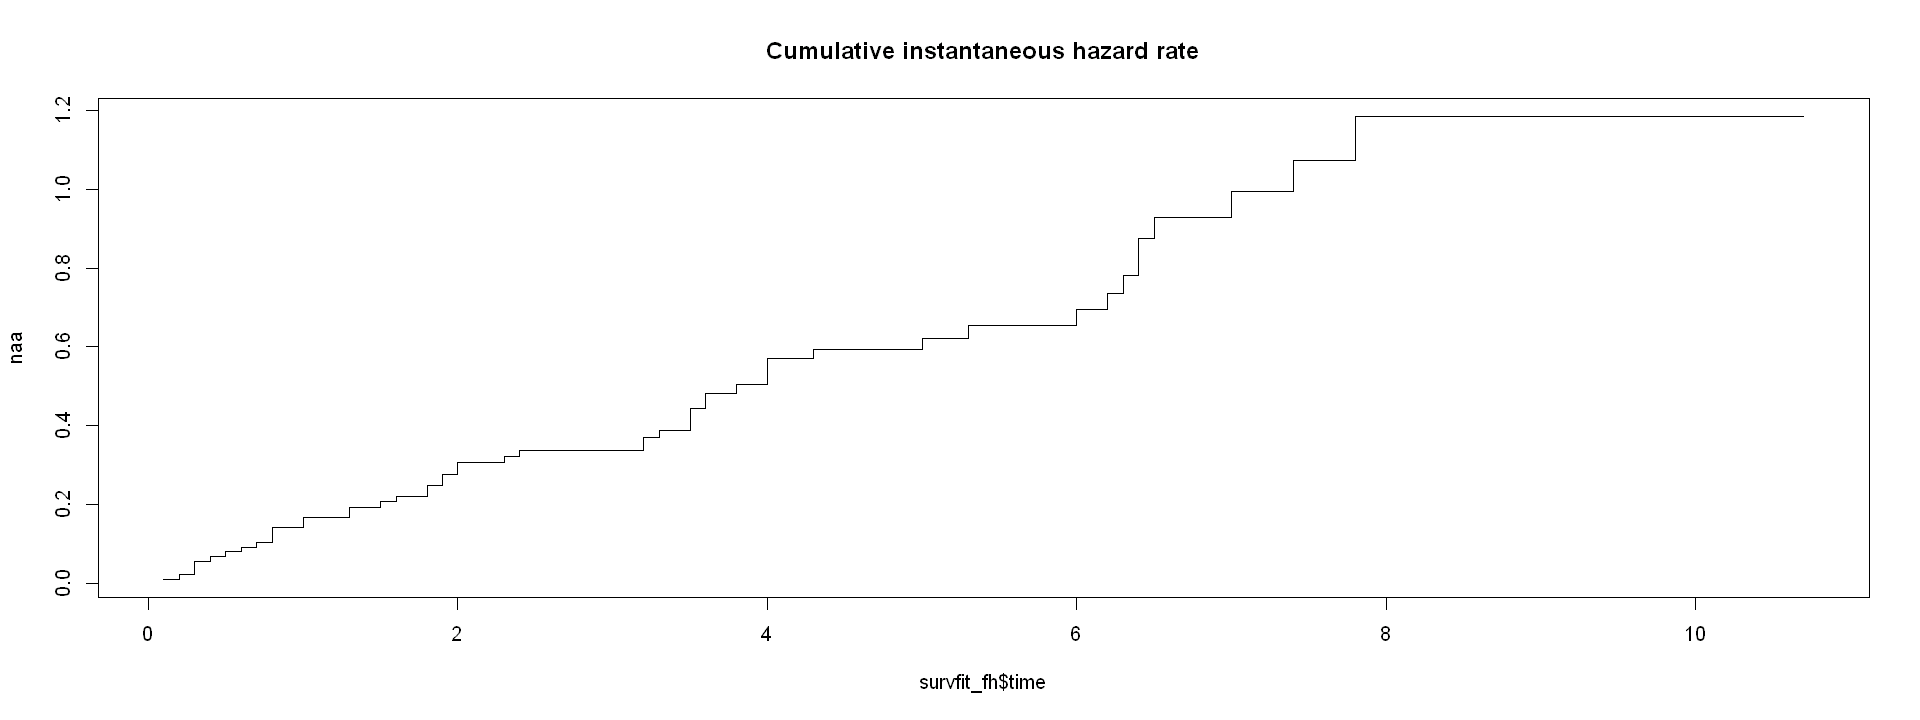

In [21]:
survfit_fh <- survfit(surv~ 1, data = surv,conf.int=0.95, 
        type="fleming-harrington",
        conf.type="plain")

naa <- -log(survfit_fh$surv) 

plot(survfit_fh$time,naa,type='s',main = "Cumulative instantaneous hazard rate")

#### c) Variables significatives pour Log-normal modèle 

In [22]:
# Fit a lognormal regression model
lognormal_model <- survreg(surv ~ stage_ord, data = donnee, dist = "lognormal")
summary(lognormal_model)


Call:
survreg(formula = surv ~ stage_ord, data = donnee, dist = "lognormal")
             Value Std. Error     z       p
(Intercept)  2.188      0.265  8.25 < 2e-16
stage_ord2  -0.228      0.441 -0.52   0.605
stage_ord3  -0.889      0.364 -2.44   0.015
stage_ord4  -1.906      0.444 -4.30 1.7e-05
Log(scale)   0.239      0.107  2.24   0.025

Scale= 1.27 

Log Normal distribution
Loglik(model)= -142.3   Loglik(intercept only)= -151.8
	Chisq= 19.05 on 3 degrees of freedom, p= 0.00027 
Number of Newton-Raphson Iterations: 4 
n= 90 


- On a les mêmes variables significatives

In [23]:
summary(lognormal_model)$coefficients["stage_ord4"]

stage_ord4 
 -1.905973

**Paramètre de la log-normal**

In [17]:
# shape parameter of the Weibull
scale <- summary(lognormal_model)$scale
print(paste("Shape parameter = ", 1/scale))

[1] "Shape parameter =  0.787425680991252"


- **Scale** représente l'écart-type des valeurs de log(X). Un plus grand scale signifie que les données de log(X) sont plus dispersées.

## Exercice 2 : Semiparametric Regression model

### Question 1 : cox’s regression with two covariates

**Breslow method**

In [18]:
# Breslow method
cox_model <- coxph(surv  ~ stage_ord + age, data = donnee, method="breslow")
summary(cox_model)

Call:
coxph(formula = surv ~ stage_ord + age, data = donnee, method = "breslow")

  n= 90, number of events= 50 

              coef exp(coef) se(coef)     z Pr(>|z|)    
stage_ord2 0.13856   1.14862  0.46231 0.300    0.764    
stage_ord3 0.63835   1.89335  0.35608 1.793    0.073 .  
stage_ord4 1.69306   5.43607  0.42221 4.010 6.07e-05 ***
age        0.01890   1.01908  0.01425 1.326    0.185    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
stage_ord2     1.149     0.8706    0.4642     2.842
stage_ord3     1.893     0.5282    0.9422     3.805
stage_ord4     5.436     0.1840    2.3763    12.436
age            1.019     0.9813    0.9910     1.048

Concordance= 0.682  (se = 0.039 )
Likelihood ratio test= 18.07  on 4 df,   p=0.001
Wald test            = 20.82  on 4 df,   p=3e-04
Score (logrank) test = 24.33  on 4 df,   p=7e-05


- Cox estime l'hazard rate donc si un coefficeint est positif  alors il augmente l'hazard rate => baisse DDV. Si exp(coef) est plus grand que 1 alors a augmente le risque (R).

- Ici le coef de ordre4 =1.69 et exp(ordre4) = 5.4 donc il augmente le hazard rate donc le risque. Cela est cohérant avec le résultat précédant. 

- Les 3 tests sont significatifs donc cela veut dire que l'on rejette l'hypothèse que nos varaibles peuvent être mises à zéro. Donc nos covariables sont significatives. Si on regarde plus en détail on voit que c'est stage_ord4 qui est la plus significative dans le modèle.


**Efron method**

In [19]:
# Efron method
cox_model <- coxph(surv  ~ stage_ord + age, data = donnee, method="efron")
summary(cox_model)

Call:
coxph(formula = surv ~ stage_ord + age, data = donnee, method = "efron")

  n= 90, number of events= 50 

              coef exp(coef) se(coef)     z Pr(>|z|)    
stage_ord2 0.14004   1.15032  0.46249 0.303   0.7620    
stage_ord3 0.64238   1.90100  0.35611 1.804   0.0712 .  
stage_ord4 1.70598   5.50678  0.42191 4.043 5.27e-05 ***
age        0.01903   1.01921  0.01426 1.335   0.1820    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
stage_ord2     1.150     0.8693    0.4647     2.848
stage_ord3     1.901     0.5260    0.9459     3.820
stage_ord4     5.507     0.1816    2.4086    12.590
age            1.019     0.9811    0.9911     1.048

Concordance= 0.682  (se = 0.039 )
Likelihood ratio test= 18.31  on 4 df,   p=0.001
Wald test            = 21.15  on 4 df,   p=3e-04
Score (logrank) test = 24.78  on 4 df,   p=6e-05


meme conclusion

- Les p-valeurs de nullité des paramètres sont encore inféroieurs à 0.05 donc le modèle est meilleur avec covaraibles.
  
- Stage_ord4 a un exp(coef) a environ 5.5 pour les 2 méthodes; Donc on  voit qu'il augmente le risque (R) et donc diminue la DDV.

### Question 2 : inférence avec les covariables significatives 

In [25]:
# Ajuster un modèle de Cox pour stage_ord == 4
cox_model <- coxph(surv ~ (stage_ord == 4), data = donnee, method = "breslow")
summary(cox_model)

Call:
coxph(formula = surv ~ (stage_ord == 4), data = donnee, method = "breslow")

  n= 90, number of events= 50 

                     coef exp(coef) se(coef)     z Pr(>|z|)    
stage_ord == 4TRUE 1.4799    4.3927   0.3647 4.058 4.95e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                   exp(coef) exp(-coef) lower .95 upper .95
stage_ord == 4TRUE     4.393     0.2277     2.149     8.978

Concordance= 0.598  (se = 0.03 )
Likelihood ratio test= 13.03  on 1 df,   p=3e-04
Wald test            = 16.47  on 1 df,   p=5e-05
Score (logrank) test = 19.56  on 1 df,   p=1e-05


- Ici on compare le stage_ord4 avec l'ensemble des variables alors que précédemment on comparait avec le stage 1.
- Stage_ord4 est significatif. exp(coef) = 4.3 donc il fait bien baisser la DDV et augmenter le R. 

### Question 3 : baseline Reliability function and its pointwise 95% IC

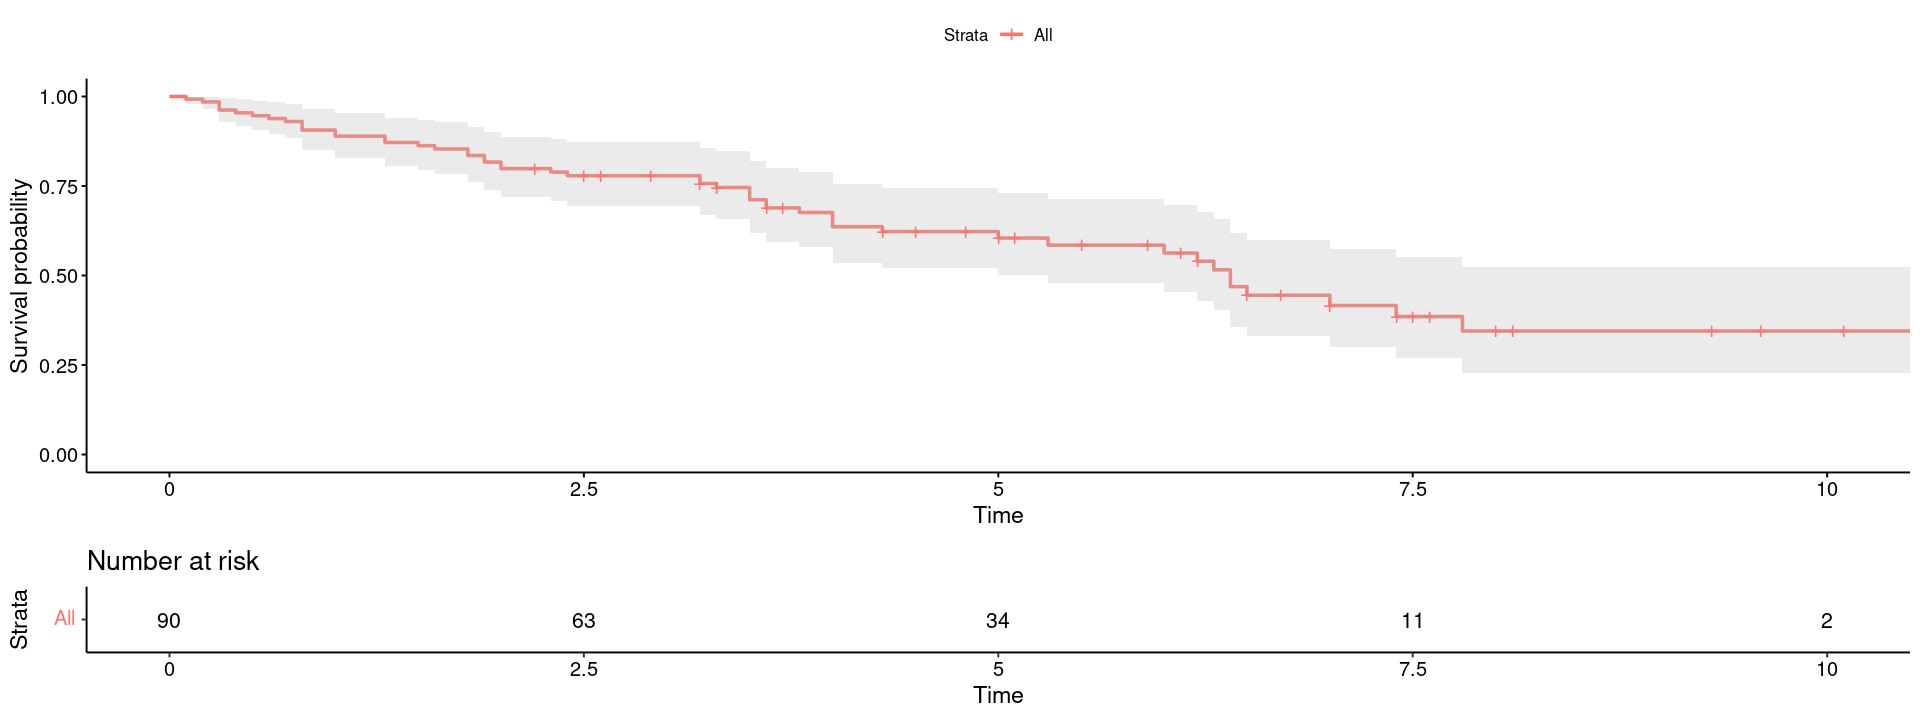

In [21]:
survfit_model <- survfit(cox_model, data = donnee, conf.int = 0.95)

# Afficher la courbe de survie séparée par sexe avec p-value
ggsurvplot(survfit_model, 
           conf.int = TRUE,              # Afficher la p-value
           risk.table = TRUE)  # Labels de la légende

## Exercice 3 :  Survival Probabilities under Cox’s Model

In [29]:
#install.packages('JM')
library(JM)

data(pbc2.id)
head(pbc2.id)

,id,years,status,drug,age,sex,year,ascites,hepatomegaly,spiders,edema,serBilir,serChol,albumin,alkaline,SGOT,platelets,prothrombin,histologic,status2
,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
1,1,1.095170,dead,D-penicil,58.76684,female,0,Yes,Yes,Yes,edema despite diuretics,14.5,261,2.60,1718,138.0,190,12.2,4,1
2,2,14.152338,alive,D-penicil,56.44782,female,0,No,Yes,Yes,No edema,1.1,302,4.14,7395,113.5,221,10.6,3,0
3,3,2.770781,dead,D-penicil,70.07447,male,0,No,No,No,edema no diuretics,1.4,176,3.48,516,96.1,151,12.0,4,1
4,4,5.270507,dead,D-penicil,54.74209,female,0,No,Yes,Yes,edema no diuretics,1.8,244,2.54,6122,60.6,183,10.3,4,1
5,5,4.120578,transplanted,placebo,38.10645,female,0,No,Yes,Yes,No edema,3.4,279,3.53,671,113.2,136,10.9,3,0
6,6,6.853028,dead,placebo,66.26054,female,0,No,Yes,No,No edema,0.8,248,3.98,944,93.0,NA,11.0,3,1


### Question 1 :  Cox’s semiparametric inference with covariates

In [30]:
donnee = pbc2.id
time = donnee$years
ev = donnee$status2

surv <- Surv(time,ev)

cox_model <- coxph(surv  ~ sex + age, data = donnee, method="breslow")
summary(cox_model)

Call:
coxph(formula = surv ~ sex + age, data = donnee, method = "breslow")

  n= 312, number of events= 140 

               coef exp(coef)  se(coef)      z Pr(>|z|)    
sexfemale -0.479757  0.618934  0.221308 -2.168   0.0302 *  
age        0.041527  1.042401  0.008316  4.993 5.93e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

          exp(coef) exp(-coef) lower .95 upper .95
sexfemale    0.6189     1.6157    0.4011     0.955
age          1.0424     0.9593    1.0255     1.060

Concordance= 0.628  (se = 0.024 )
Likelihood ratio test= 32.54  on 2 df,   p=9e-08
Wald test            = 34.21  on 2 df,   p=4e-08
Score (logrank) test = 34.65  on 2 df,   p=3e-08


- Les test nous donne des p-valeurs significatives donc on peut conclure que les covariables dans ce modèle sont significatives. Si on regarde plus précisement on voit que l'age est la covariable la plus influente. 

- De plus, l'age fait augmenter notre hazarf function (risk) donc diminuer notre durée de vie, exp(coef) = 1.04 > 1. Au contraire, le sexe F fait diminuer le hazard function (risk) et donc augmenter la durée de vie, exp(coef) = 0.6 < 1.

- Donc un individu qui a 10 de plus qu'un autre a une DDV plus courte que l'autre. Un individu qui a 10 de plus a un risque exp(10*coef) plus élevé. Ca revient a dire que c'est 1.04^10 (exp(coef)^10) plus élevé.

### Question 2 : new dataframe 

In [34]:
df <- data.frame(
  sex = c("male", "male", "female", "female"),
  age = c(40, 50, 40, 50)
)

# Afficher le DataFrame
print(df)

     sex age
1   male  40
2   male  50
3 female  40
4 female  50


### Question 3 :  survival estimates

Warning message in (function (survsummary, times, survtable = c("cumevents", "risk.table", :
"The length of legend.labs should be 1"


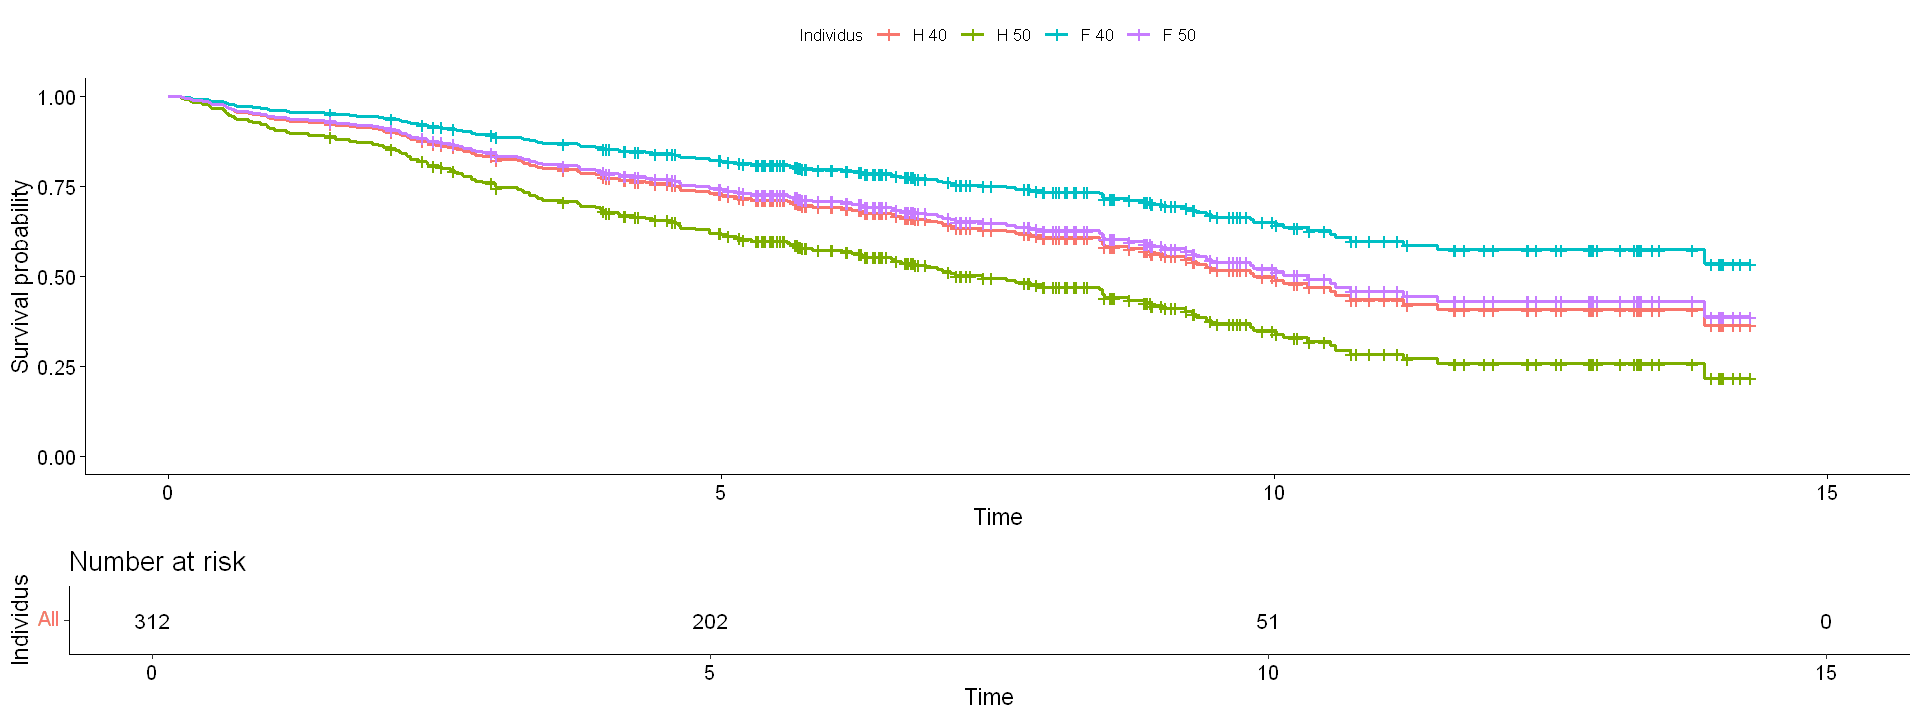

In [37]:
survfit_newdata <- survfit(cox_model, newdata = df)

# Afficher la courbe de survie séparée par sexe avec p-value
ggsurvplot(
  survfit_newdata, 
  data = df,  
  conf.int = FALSE,                # Afficher les intervalles de confiance
  #pval = TRUE, 
  risk.table = TRUE,              # Ajouter un tableau des risques
  legend.title = "Individus",     # Titre de la légende
  legend.labs = c("H 40", "H 50", "F 40", "F 50"))